In [187]:
## Pyro GP tutorial used as starting point:
## https://pyro.ai/examples/gp.html

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
import arviz

# Partition observations
X = np.asarray([x / 29 for x in range(1, 31)])
np.random.shuffle(X)
Y = 6 * np.square(X) - np.square(np.sin(6 * np.pi * X)) - 5 * np.power(X, 4) + 3 / 2 + np.random.normal(0.0, 0.01, 30)
Xtrain, Xtest, Ytrain, Ytest = torch.tensor(X[10:]), torch.tensor(X[:10]), torch.tensor(Y[10:]), torch.tensor(Y[:10])

### Selecting a suitable model

In [188]:
# We chose a GP regression model and the Matern 3/2 kernel. In this setup, we have three hyper-parameters.
# I) The variance of the kernel, II) the lengthscale of the kernel, and III) the gaussian noise of the model.
# We chose to let the gaussian noise be fixed and equal to the noise of our data, while keeping the variance
# and lengthscale of the kernel variable. The prior distrubition we chose is a multivariate normal
# distribution (i.e. we consider the variance and lengthscale as normally distributed), with mean and variance
# based on what seems reasonable for the Matern 3/2 kernel, based on the lecture slides.

# Define model
class MyGPModel():
    def __init__(self, kernel):
        self.kernel = kernel
    
    def __call__(self, xs, ys=None):
        n = xs.shape[0]
        self.kernel.lengthscale = pyro.sample("lengthscale", pdist.LogNormal(0.0, 1.0))
        self.kernel.variance = pyro.sample("variance", pdist.LogNormal(0.0, 1.0))
        gp_model =  gp.models.GPRegression(xs, ys, self.kernel, noise=torch.tensor(0.01))
        return gp_model.model()

# Define kernel
def kernel(theta):
    return gp.kernels.Matern32(input_dim=1, variance=theta[0], lengthscale=theta[1])

# Define model
def model(xs, ys, kernel):
    return gp.models.GPRegression(xs, ys, kernel, noise=torch.tensor(0.01))

# Computes log-likelihood
def logLikelihood(xs, ys, kernel, theta):
    # See derivation in report
    t1 = 0.5 * torch.transpose(ys, 0, 0) * torch.linalg.inv(kernel.forward(xs)) * ys
    t2 = 0.5 * torch.log(torch.linalg.det(kernel.forward(xs)))
    t3 = 15.0 * torch.log(2 * torch.tensor(np.pi))
    return (- t1 - t2 - t3) * prior.log_prob(theta)

# Pick prior distributions
pyro.clear_param_store()
some_theta = [torch.tensor(1.5),torch.tensor(1)]
k = kernel(some_theta)
gpr = model(Xtrain, Ytrain, k)
gpr.kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))

### Compute posterior predictive

In [189]:
optimizer = torch.optim.SGD(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))

variance = 2.35556697845459
lengthscale = 0.1623966097831726
noise = 0.0005297301686368883


### Using NUTS

In [190]:
# Model is GP model from pyro
W = 100 # Number of warmup steps
C = 1 # Number of chains
S = 500 # Number of samples used in prediction
pyro.clear_param_store()
gp_kernel = kernel(some_theta)
# gp_model_nuts = model(Xtrain, Ytrain)
# guide = pyro.infer.autoguide.AutoDelta(model)

gp_model = MyGPModel(gp_kernel)
nuts_kernel = pyro.infer.NUTS(gp_model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=S, num_chains=C, warmup_steps=W)
mcmc.run(Xtrain, Ytrain)

Sample: 100%|██████████| 600/600 [10:26,  1.04s/it, step size=2.05e-03, acc. prob=0.711]


#### Checking quality of samples using arviz

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:  (y_dim_0: 20)
Coordinates:
  * y_dim_0  (y_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    y        (y_dim_0) float64 0.5911 1.818 2.823 2.02 ... 1.967 1.862 0.8551
Attributes:
    created_at:                 2024-01-18T18:24:52.899796
    arviz_version:              0.17.0
    inference_library:          pyro
    inference_library_version:  1.8.6
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
lengthscale  0.185  0.039   0.119    0.258      0.006    0.004      43.0   
variance     3.562  1.620   1.411    6.825      0.306    0.219      28.0   

             ess_tail  r_hat  
lengthscale     157.0    NaN  
variance        131.0    NaN  


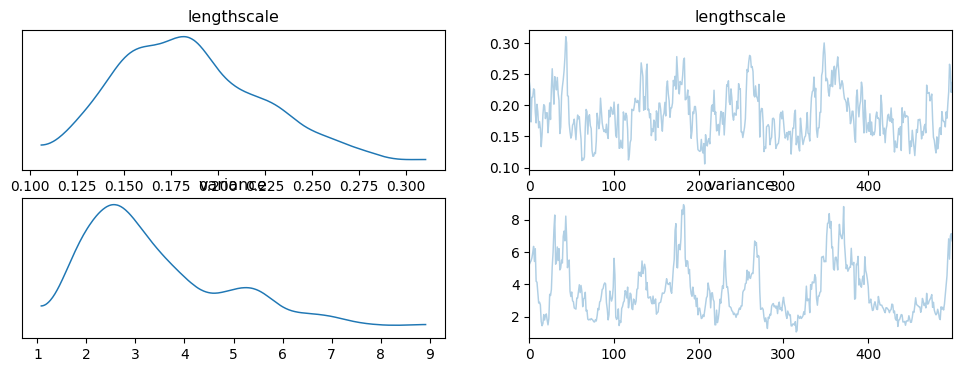

array([<Axes: title={'center': 'lengthscale'}>,
       <Axes: title={'center': 'variance'}>], dtype=object)

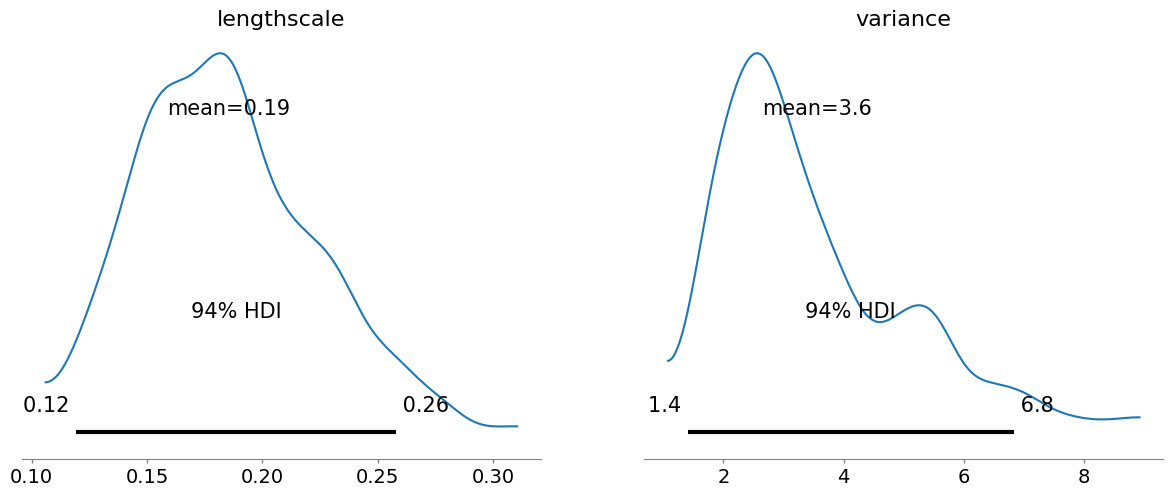

In [191]:
posterior_samples = mcmc.get_samples()
data = arviz.from_pyro(mcmc)
print(data['observed_data'])
summary = arviz.summary(data)
print(summary)
arviz.plot_trace(data)
plt.show()
arviz.plot_posterior(data)

#### Computing approximate posterior likelihood

In [198]:
pyro.clear_param_store()
posterior_predictive = pyro.infer.Predictive(gp_model, posterior_samples=posterior_samples, return_sites=['observed_data', 'variance'])(Xtest, None)
print(posterior_predictive)
data = arviz.from_pyro(mcmc)
print(data['observed_data'])
summary = arviz.summary(data)
print(summary)

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


{'variance': tensor([5.2385, 5.3636, 5.4600, 5.6381, 5.9665, 6.3499, 5.4179, 6.2007, 4.1946,
        4.1397, 3.4666, 2.8560, 2.9054, 2.7418, 1.7195, 1.4542, 1.5890, 2.1409,
        1.8032, 2.0828, 2.1825, 1.8098, 1.5075, 1.8897, 3.3928, 3.3166, 3.6850,
        5.0862, 5.9778, 7.3731, 8.2855, 5.2497, 5.4099, 6.3127, 5.4835, 6.2081,
        4.8981, 5.0126, 5.5039, 5.3255, 6.9731, 7.2927, 6.6890, 8.2177, 6.9090,
        5.0352, 5.4013, 5.5086, 3.5876, 3.2574, 3.5345, 2.9879, 2.9373, 2.5501,
        2.5178, 2.4782, 3.1644, 3.1722, 3.5813, 3.9829, 3.4951, 3.9373, 3.5569,
        2.6277, 3.1067, 3.1743, 3.5167, 2.3626, 2.4132, 1.8536, 1.8145, 1.8537,
        1.8158, 1.8939, 1.8492, 1.7941, 1.7016, 1.6847, 1.8252, 1.7474, 2.0700,
        2.5213, 2.4402, 2.9177, 2.9805, 3.2903, 3.6951, 3.7347, 3.9981, 4.0976,
        4.0362, 2.8751, 2.4667, 1.8142, 2.1323, 3.5948, 3.2269, 2.9755, 3.1676,
        3.8233, 5.6133, 4.5780, 1.9833, 1.8416, 1.9329, 2.4923, 1.4634, 1.7449,
        1.6562, 2.5206, 2.6